In [1]:
import wandb
from src.utils.conf_utils import *
from src.utils.conf_utils import get_cfg
from src.models.part_vit_module import PARTViTModule
from src.callbacks import ReconstructionLogger
import torch
from matplotlib import pyplot as plt

In [2]:
wandb_kwargs = {
    "id": "ukjrb3lq",
    "entity": "dgcnz",
    "project": "PARTv2",
}


In [3]:
def get_model_artifact_name(entity: str, project: str, id: str, version: str="v0"):
    return f"{entity}/{project}/model-{id}:{version}"

In [4]:
# Download the model checkpoint from wandb
# artifact_full_name = "dgcnz/PARTv2/model-ukjrb3lq:v0"
artifact, out_dir = download_artifact(get_model_artifact_name(**wandb_kwargs))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact model-ukjrb3lq:v0, 980.45MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2


In [5]:
cfg = get_cfg(
    [
        "experiment=hs_part_im1k_pairdiff_mlp",
        "data.batch_size=4",
        "data.num_workers=0",
        "model.sample_mode=offgrid",
    ]  # , "data.cache_dir=null"]
)

In [6]:
import sys
import timm
from timm.models.vision_transformer import VisionTransformer
sys.modules['src.models.components.part_utils'] = sys.modules['src.models.components.utils.part_utils']
module = PARTViTModule.load_from_checkpoint(out_dir / "epoch=41-step=52584.ckpt")
# module.net.backbone.set_input_size((224, 224), (32, 32))
# module.to('cuda')

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [7]:
module.hparams.sample_mode = "offgrid"

In [8]:
datamodule = get_datamodule_from_cfg(cfg)

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.


In [9]:
datamodule.setup()
train_dataloader = datamodule.test_dataloader()


INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Finished setting up datasets.


In [10]:
train_batch = next(iter(train_dataloader))
train_batch = datamodule.transfer_batch_to_device(train_batch, "cuda", 0)

In [11]:
with torch.no_grad():
    output = module.model_step(train_batch)

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torch/functional.py:540: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4311.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:

list(output.keys())

['loss',
 'symmetry_loss',
 'pred_T',
 'gt_T',
 'x',
 'x_original',
 'patch_positions',
 'patch_pair_indices']

In [13]:
[k for k, v in output.items() if v is None]

['symmetry_loss']

In [14]:
[v.shape for v in output.values() if v is not None]

[torch.Size([]),
 torch.Size([4, 38416, 2]),
 torch.Size([4, 38416, 2]),
 torch.Size([4, 3, 224, 224]),
 torch.Size([4, 3, 224, 224]),
 torch.Size([4, 196, 2]),
 torch.Size([4, 38416, 2])]

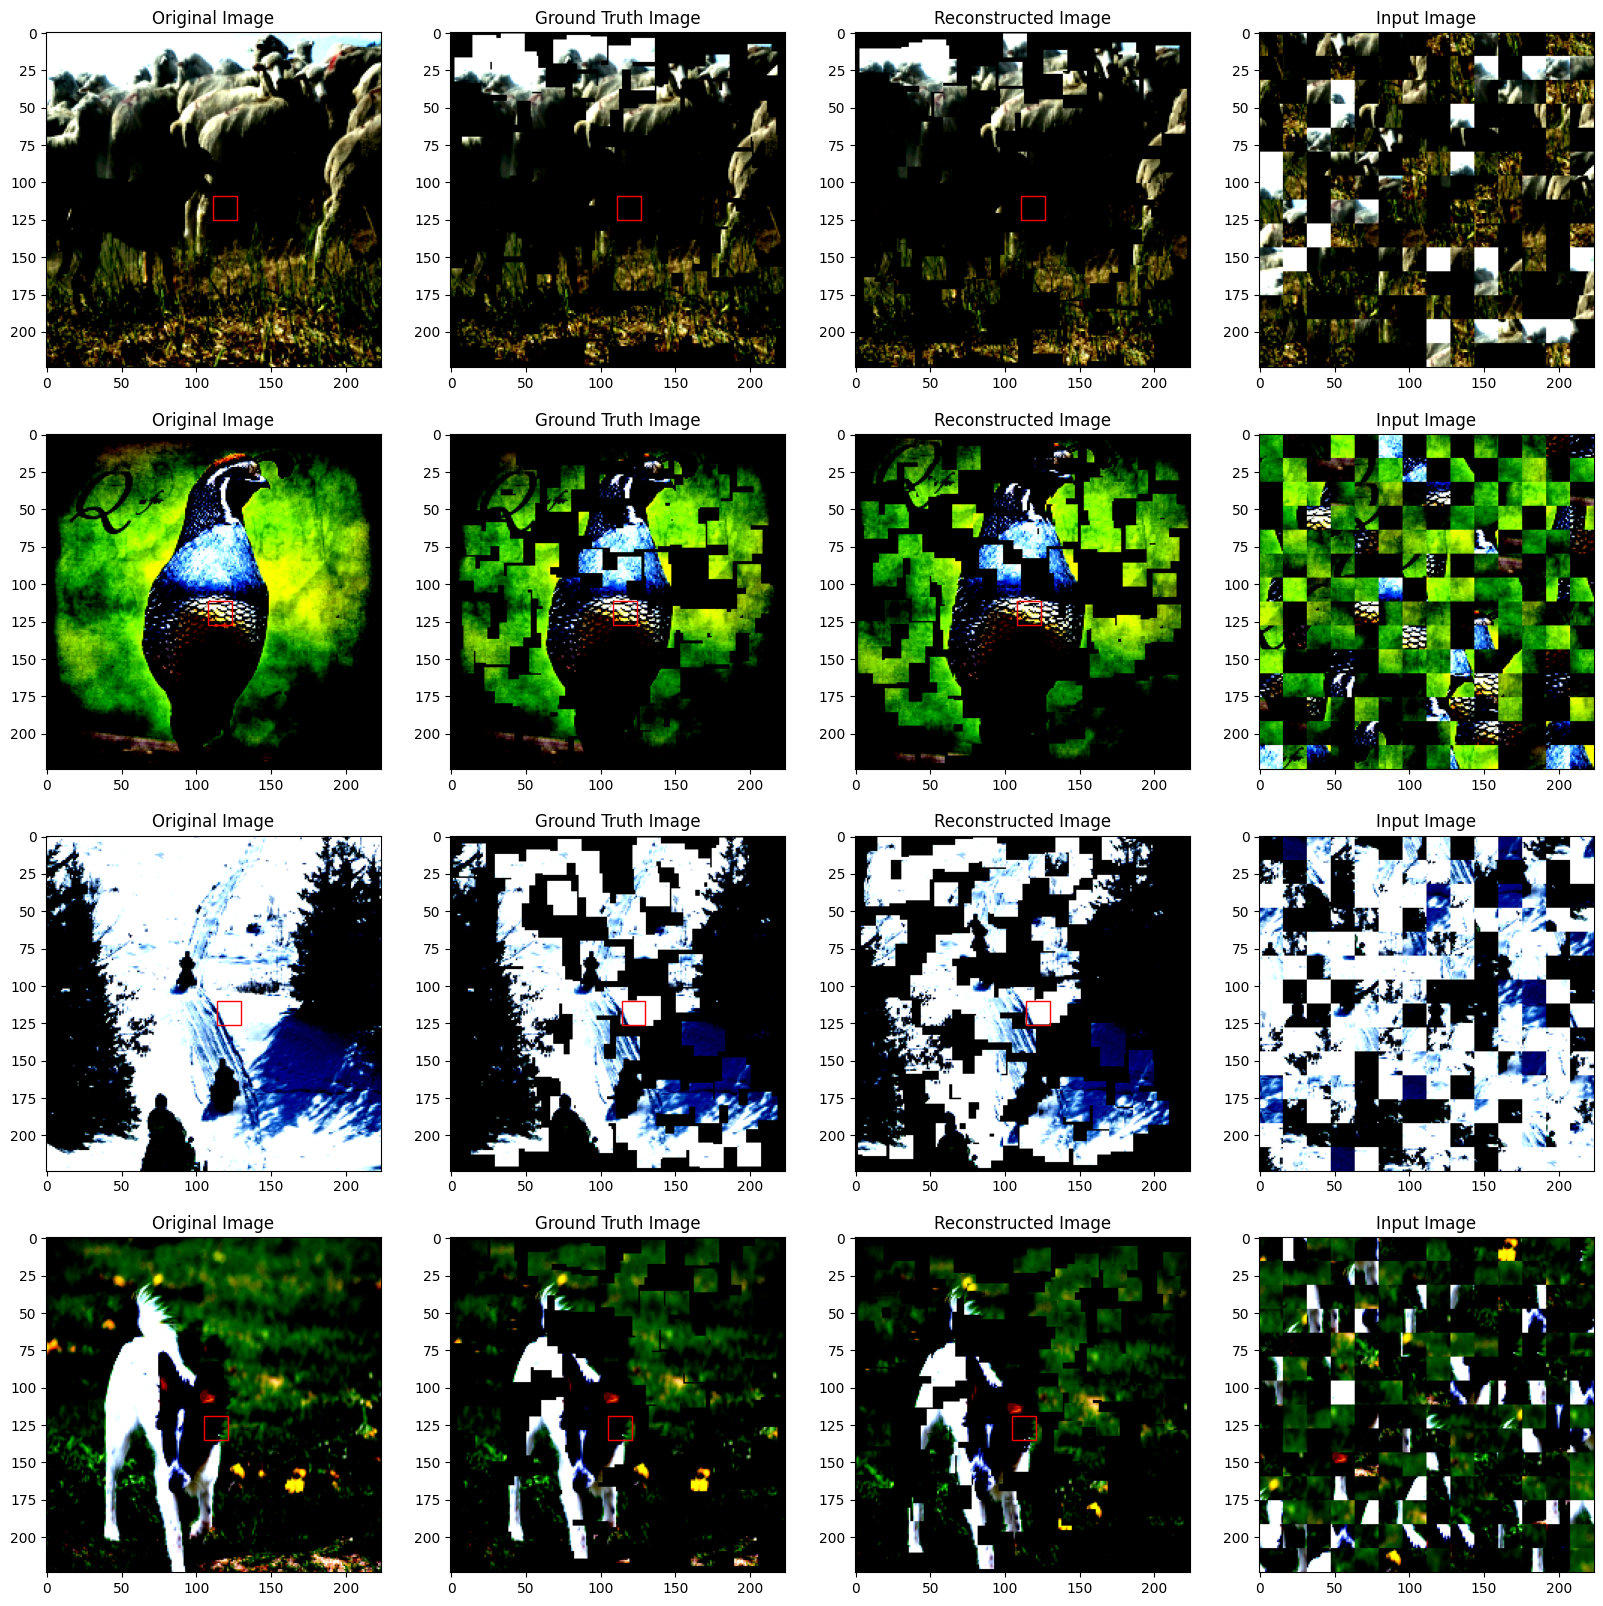

In [15]:
# #     def _plot(self, pl_module, x_original, x, patch_positions, pred_T, patch_pair_indices):
callback = ReconstructionLogger(-1, num_samples=4)
fig_rec, fig_prov = callback._plot(
    module,
    output["x_original"].detach().cpu(),
    output["x"].detach().cpu(),
    output["patch_positions"].detach().cpu(),
    output["pred_T"].detach().cpu(),
    output["patch_pair_indices"].detach().cpu(),
)
plt.close(fig_prov)


In [16]:
fig_rec.show()

/tmp/ipykernel_17824/3425340542.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_rec.show()


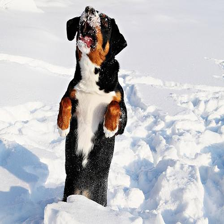

In [17]:
from PIL import Image
img = Image.open("../../artifacts/dog.jpg").convert("RGB").resize((224, 224))
img.show()
img

In [18]:
datamodule.hparams.test_transform

Compose(
      RGB()
      ToImage()
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [19]:
test_transform = datamodule.test_transform
test_transform

Compose(
      RGB()
      ToImage()
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


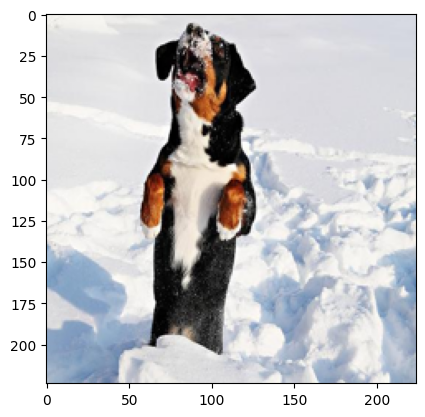

In [20]:
# batch = datamodule.hparams.test_transform(img)
from torchvision.transforms.v2.functional import to_image, to_tensor
batch = to_tensor(img)
# plot batch
plt.imshow(batch.permute(1, 2, 0))


In [21]:
type(batch)

torch.Tensor

In [22]:
with torch.no_grad():
    output = module.model_step({"image": batch.unsqueeze(0).cuda()})



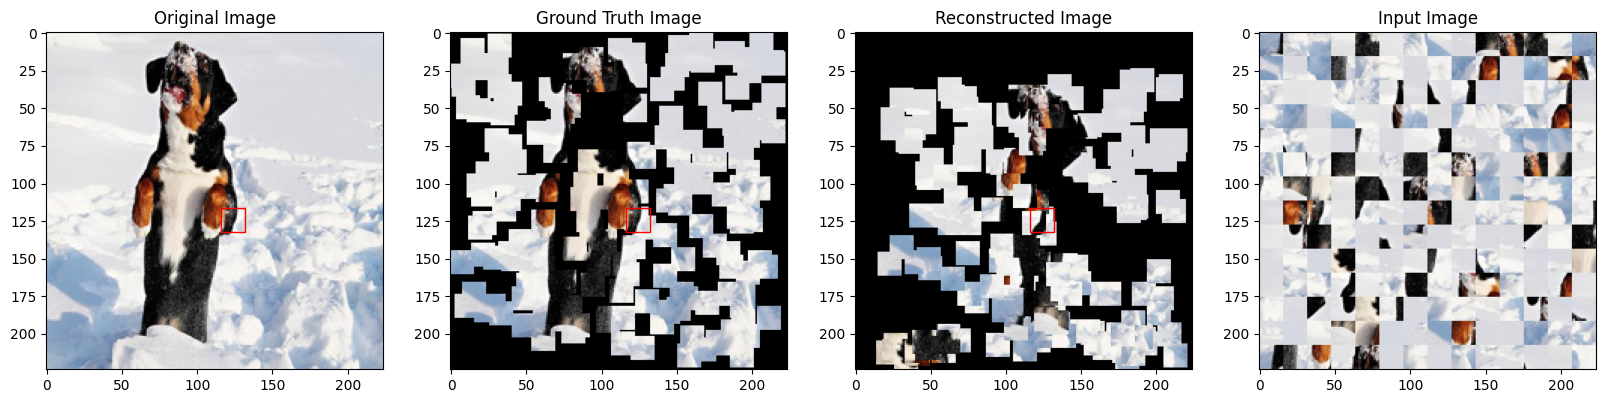

In [23]:
callback = ReconstructionLogger(-1, num_samples=4)
fig_rec, fig_prov = callback._plot(
    module,
    output["x_original"].detach().cpu(),
    output["x"].detach().cpu(),
    output["patch_positions"].detach().cpu(),
    output["pred_T"].detach().cpu(),
    output["patch_pair_indices"].detach().cpu(),
)
plt.close(fig_prov)


In [24]:
import timm
from timm.models.vision_transformer import VisionTransformer
from src.models.components.part_vit import PARTViT
# load vit 
vit = timm.create_model("vit_base_patch16_224", pretrained=False)

# move the state dict of module.net.backbone to vit
vit.load_state_dict(module.net.backbone.state_dict(), strict=False)


_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'head.weight', 'head.bias'], unexpected_keys=[])

In [25]:
vit.reset_classifier(1000, "")

In [ ]:
vit.cuda()
vit(batch.unsqueeze(0).cuda()).shape


torch.Size([1, 197, 1000])